# Packages

In [1]:
from covid19_DTM.models.utils import output_to_visuals
from covid19_DTM.models.utils import initialize_COVID19_SEIQRD_hybrid_vacc
from covid19_DTM.visualization.output import _apply_tick_locator 
from covid19_DTM.models.QALY import lost_QALYs
from covid19_DTM.models.QALY import life_table_QALY_model
life_table = life_table_QALY_model()
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import multiprocessing as mp

# Define simulation settings

In [2]:
# Number of simulations
N=10
# Number of neg. binomial draws/ simulation
K=10
# Number of cpu's
processes=int(mp.cpu_count()/2)
# Number of age groups
age_stratification_size=10
# End of simulation
end_sim='2021-07-01'
# Confidence level used to visualise model fit
conf_int=0.05

# Initialize the model

In [3]:
model, BASE_samples_dict, initN = initialize_COVID19_SEIQRD_hybrid_vacc(age_stratification_size=age_stratification_size, start_date='2020-03-15')

warmup = float(BASE_samples_dict['warmup'])
dispersion = float(BASE_samples_dict['dispersion'])
start_sim = BASE_samples_dict['start_calibration']

# Perform simulations

In [4]:
from covid19_DTM.models.draw_functions import draw_fnc_COVID19_SEIQRD_hybrid_vacc as draw_function
out_sim = model.sim([start_sim,end_sim], warmup=warmup, processes=processes, N=N, samples=BASE_samples_dict, draw_function=draw_function)

# QALY calculations

In [5]:
out_AD = lost_QALYs(out_sim,AD_non_hospitalised=True)
out_no_AD = lost_QALYs(out_sim,AD_non_hospitalised=False)

# Visualisations

In [6]:
abs_dir = os.getcwd()
result_folder = '../../results/covid19_DTM/analysis/QALY/long_COVID'

# Verify that the paths exist and if not, generate them
if not os.path.exists(os.path.join(abs_dir,result_folder)):
    os.makedirs(os.path.join(abs_dir,result_folder))

states = ['QALY_NH', 'QALY_C', 'QALY_ICU','QALY_D']
titles = ['Non-hospitalised', 'Cohort', 'ICU','Deaths']
colors = ['green','yellow','red','black']

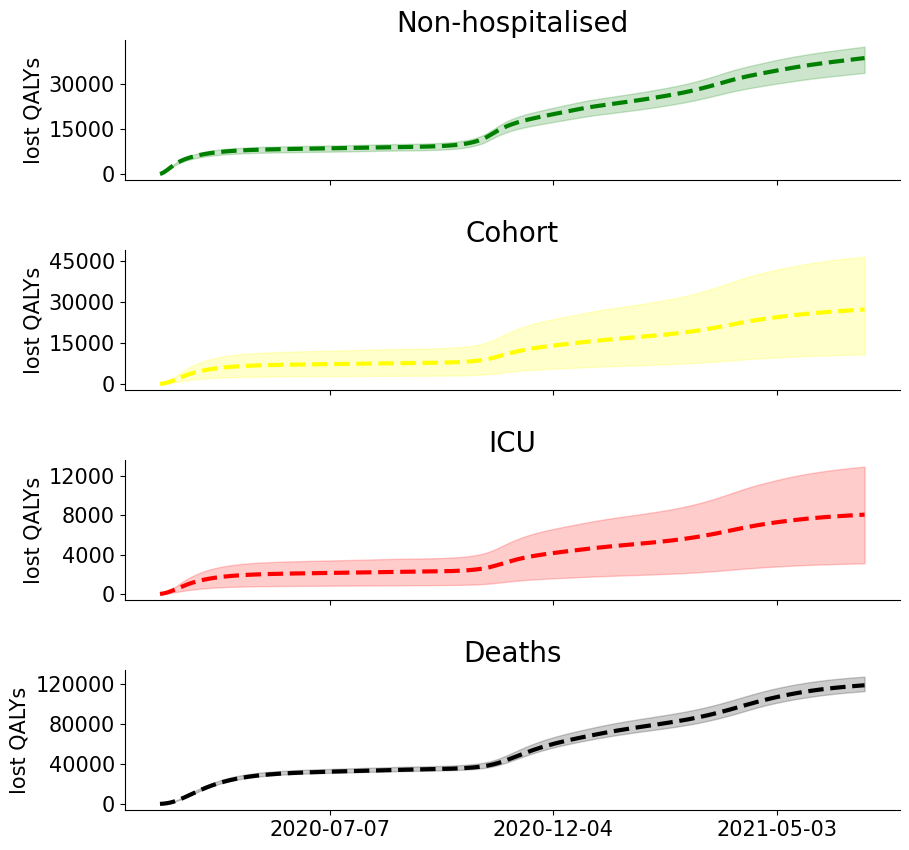

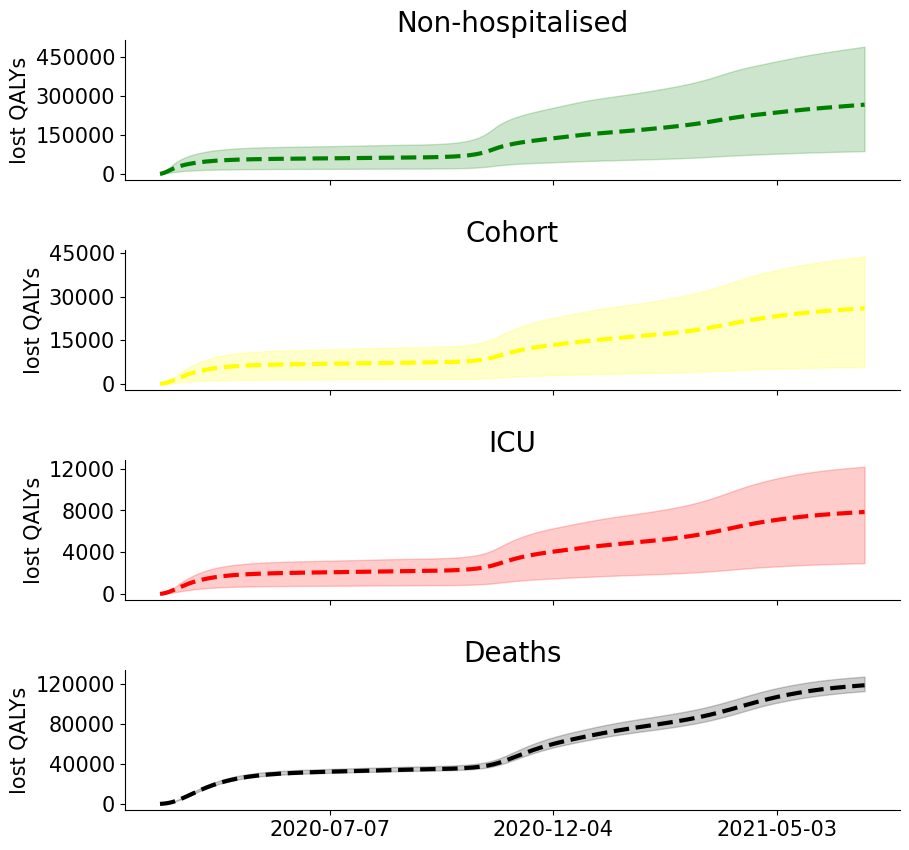

In [20]:
for scenario,out in zip(['no_AD','AD'],[out_no_AD,out_AD]):
    simtime = out['date'].values

    fig,axs = plt.subplots(nrows=4,ncols=1,sharex=True,figsize=(10,10))
    axs=axs.reshape(-1)
    for ax, QALYs, title, color in zip(axs, states,titles,colors):

        mean = out[QALYs].sum('doses').sum('age_groups').mean('draws')
        lower = np.quantile(out[QALYs].sum('doses').sum('age_groups'),0.025,axis=0)
        upper = np.quantile(out[QALYs].sum('doses').sum('age_groups'),0.975,axis=0)

        ax.plot(simtime,mean,'--', color=color)
        ax.fill_between(simtime, lower, upper,alpha=0.20, color = color)

        ax = _apply_tick_locator(ax)
        ax.set_title(title,fontsize=20)
        ax.set_ylabel('lost QALYs')
        ax.grid(False)

    plt.subplots_adjust(hspace=0.5)
    plt.show()
    #fig.savefig(os.path.join(abs_dir,result_folder,f'QALY_losses_{scenario}.png'))

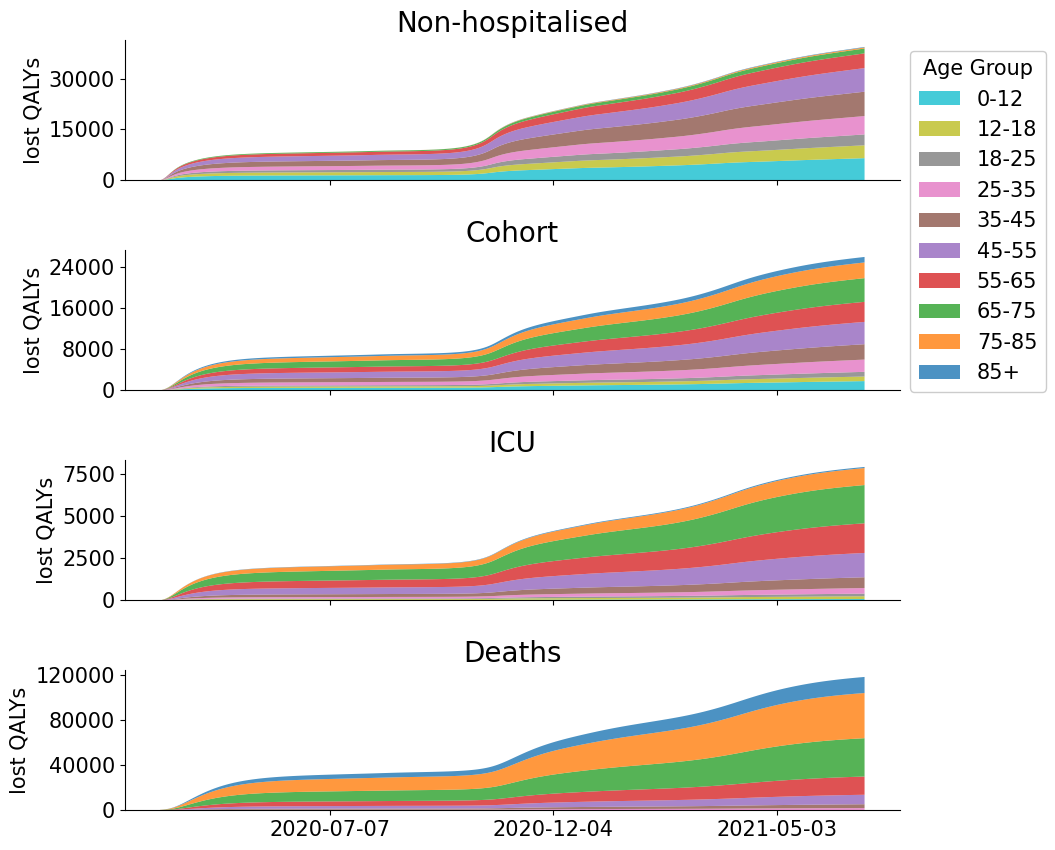

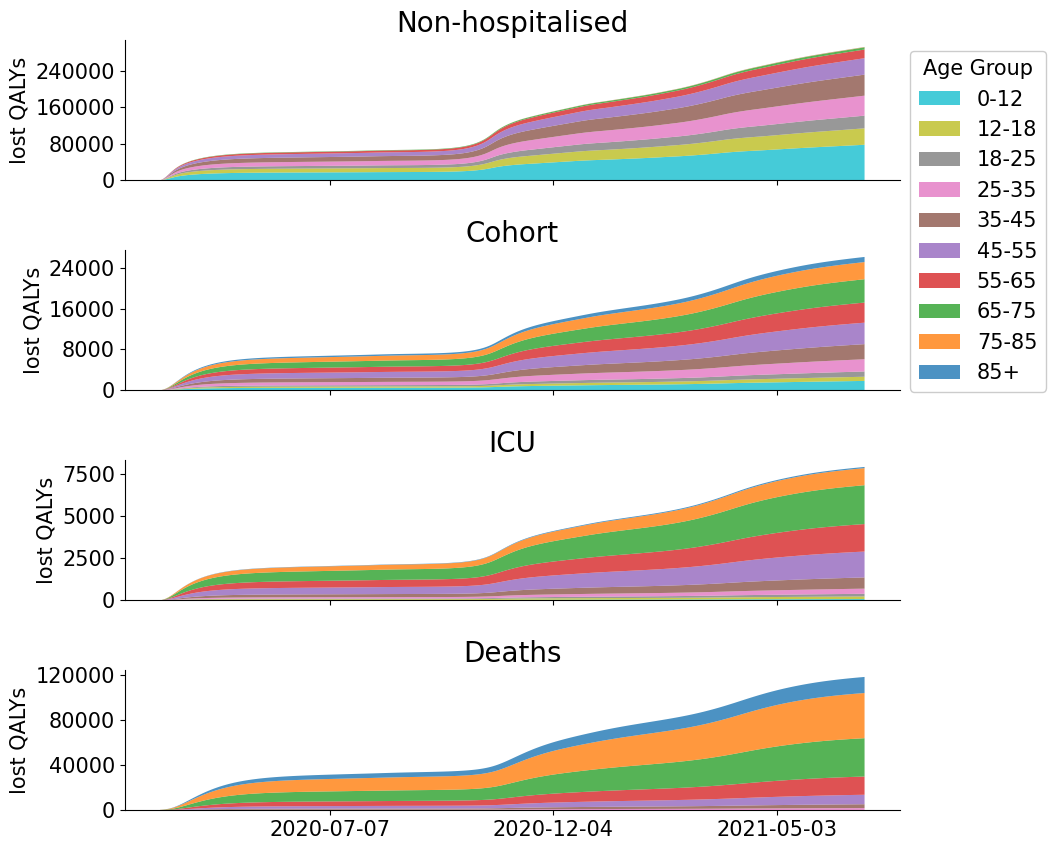

In [ ]:
for scenario,out in zip(['no_AD','AD'],[out_no_AD,out_AD]):    
# QALYS per age group
    Palette=cm.get_cmap('tab10_r', initN.size).colors
    age_group=['0-12','12-18','18-25','25-35','35-45','45-55','55-65','65-75','75-85','85+']

    fig, axs = plt.subplots(4,figsize=(10,10),sharex=True)
    axs=axs.reshape(-1)
    for ax, QALYs, title, color in zip(axs,states,titles,colors):
        ax.stackplot(simtime,np.transpose(out[QALYs].mean(dim="draws").sum(dim='doses').values),linewidth=3, labels=age_group, colors=Palette, alpha=0.8)
        ax.set_title(title,fontsize=20)
        ax.set_ylabel('lost QALYs')
        ax = _apply_tick_locator(ax) 
        ax.grid(False)
    axs[0].legend(fancybox=True, frameon=True, framealpha=1, fontsize=15,title='Age Group', loc="upper left", bbox_to_anchor=(1,1)) 

    plt.subplots_adjust(hspace=0.5)
    plt.show()
    #fig.savefig(os.path.join(abs_dir,result_folder,f'QALY_losses_per_age_group_{scenario}.png'), dpi=600)

<Figure size 640x480 with 0 Axes>

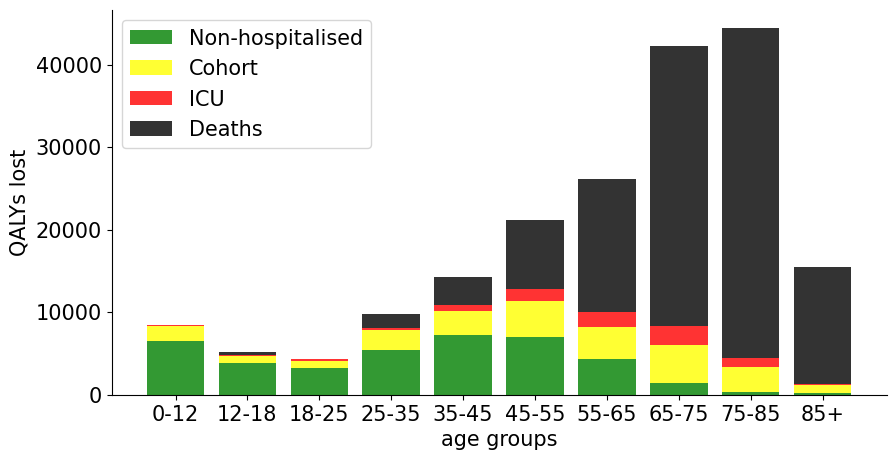

<Figure size 640x480 with 0 Axes>

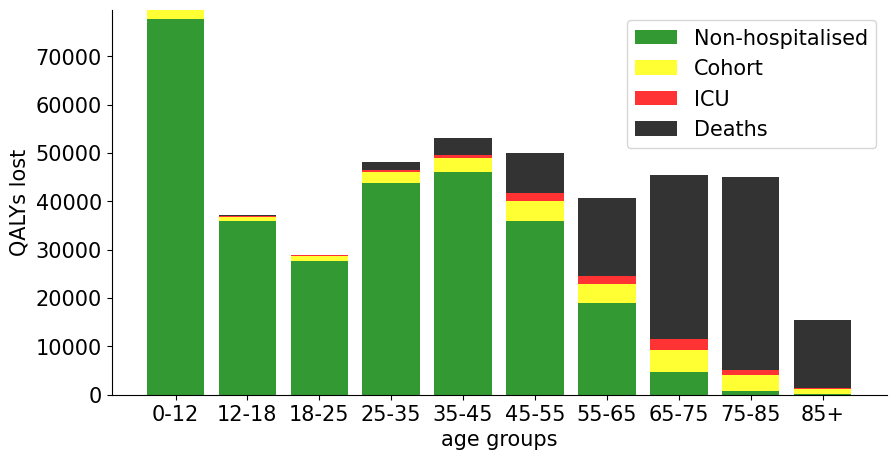

In [ ]:
for scenario,out in zip(['no_AD','AD'],[out_no_AD,out_AD]):
# QALYS per age group
    Palette=cm.get_cmap('tab10_r', initN.size).colors
    plt.set_cmap('Set1')
    age_group=['0-12','12-18','18-25','25-35','35-45','45-55','55-65','65-75','75-85','85+']

    bottom = np.zeros(len(age_group))
    fig, ax = plt.subplots(figsize=(10,5))
    for state, color, label in zip(states,colors,titles):

        y = out[state].mean('draws').sum('doses')[-1].values
        ax.bar(age_group,y, color=color, alpha=0.8,bottom=bottom,label=label)
        ax.grid(False)
        bottom += y

    ax.legend() 
    ax.set_ylabel('QALYs lost')
    ax.set_xlabel('age groups')
    plt.show()
    #fig.savefig(os.path.join(abs_dir,result_folder,f'QALY_losses_per_age_group_{scenario}.png'), dpi=600)